# 数据预处理

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import pandas as pd

In [ ]:
with open('/content/drive/MyDrive/data/haihua/train.json','r',encoding='utf-8')as f: #读入json文件
    train_data = json.load(f)
    
train_df = []

for i in range(len(train_data)): #将每个文章-问题-答案作为一条数据
    data = train_data[i]
    content = data['Content']
    questions = data['Questions']
    for question in questions:
        question['Content'] = content
        train_df.append(question)
        
train_df[0]

{'Answer': 'A',
 'Choices': ['A．作者写作此诗之时，皮日休正患病居家，闭门谢客，与外界不通音讯。',
  'B．由于友人患病，原有的约会被暂时搁置，作者游春的诗篇也未能写出。',
  'C．作者虽然身在书斋从事教学，但心中盼望能走进自然，领略美好春光。',
  'D．尾联使用了关于沈约的典故，可以由此推测皮日休所患的疾病是目疾。'],
 'Content': '奉和袭美抱疾杜门见寄次韵  陆龟蒙虽失春城醉上期，下帷裁遍未裁诗。因吟郢岸百亩蕙，欲采商崖三秀芝。栖野鹤笼宽使织，施山僧饭别教炊。但医沈约重瞳健，不怕江花不满枝。',
 'Q_id': '000101',
 'Question': '下列对这首诗的理解和赏析，不正确的一项是'}

In [ ]:
train_df =  pd.DataFrame(train_df) #转换成csv表格更好看一点

train_df.head()

,Question,Choices,Answer,Q_id,Content
0,下列对这首诗的理解和赏析，不正确的一项是,"[A．作者写作此诗之时，皮日休正患病居家，闭门谢客，与外界不通音讯。, B．由于友人患病，原...",A,000101,奉和袭美抱疾杜门见寄次韵 陆龟蒙虽失春城醉上期，下帷裁遍未裁诗。因吟郢岸百亩蕙，欲采商崖三...
1,1. 文中“肆虐”“凋凌”“昼夜兼程”“版图”“稚嫩”“嫣然”“抱憾退出”的词语中，有错别字...,"[A. 肆虐 凋凌, B. 集结 昼夜兼程, C. 版图 稚嫩, D. 嫣然 抱憾退出]",A,000201,隆冬之际，西伯利亚的寒流（笼罩/席卷）欧亚大陆，狂风肆虐，草木凋凌，而那些春天的元素——温暖...
2,依次选用文中括号里的词语，最恰当的一项是,"[A. 席卷 系 扩展, B. 笼罩 停 扩展, C. 席卷 停 扩充, D. ...",A,000202,隆冬之际，西伯利亚的寒流（笼罩/席卷）欧亚大陆，狂风肆虐，草木凋凌，而那些春天的元素——温暖...
3,下列对材料相关内容的理解，不正确的一项是,[A.量子通信把量子物理与信息技术结合起来，利用量子调控技术对信息进行编码、存储、传输和操纵...,D,000301,材料一：日前，中国科学院在京召开新闻发布会对外宣布“墨子号”进行科学实验卫星提前并圆满实现全...
4,下列对材料相关内容的概括和分析，不正确的一项是,[A.利用“墨子号”科学实验卫星研究量子密钥发布和量子隐形形态的量子通信技术，对国家信息安全...,C,000302,材料一：日前，中国科学院在京召开新闻发布会对外宣布“墨子号”进行科学实验卫星提前并圆满实现全...


In [ ]:
with open('/content/drive/MyDrive/data/haihua/validation.json','r',encoding='utf-8')as f:
    test_data = json.load(f)
    
test_df = []

for i in range(len(test_data)):
    data = test_data[i]
    content = data['Content']
    questions = data['Questions']
    cls = data['Type']
    diff = data['Diff']
    for question in questions:
        question['Content'] = content
        question['Type'] = cls
        question['Diff'] = diff
        test_df.append(question)
        
test_df =  pd.DataFrame(test_df)
test_df.head()

,Question,Choices,Q_id,Content,Type,Diff
0,文中“自是豪强屏息”中“屏”的意思是,"[A、屏住呼吸, B、收敛行迹, C、退避迁徙, D、抑止打压]",000101,周鼎传①公讳鼎，字实甫，自为童子时即以言动自持，趋立多中礼。早岁善属文，补邑诸生，坚意嗜读，...,11,1
1,文中“多意沮而寝”中“寝”的意思是,"[A、睡觉, B、丑陋, C、隐蔽, D、停止]",000102,周鼎传①公讳鼎，字实甫，自为童子时即以言动自持，趋立多中礼。早岁善属文，补邑诸生，坚意嗜读，...,11,1
2,第④段断句正确的一项是,"[A、立捕两奴/及舟械至奴/犹称相国/从者意不下。, B、立捕两奴/及舟/械至奴/犹称相国/...",000103,周鼎传①公讳鼎，字实甫，自为童子时即以言动自持，趋立多中礼。早岁善属文，补邑诸生，坚意嗜读，...,11,1
3,"下列对文中""三年权知礼部贡举会大雪苦寒士坐庭中噤未能言轼宽其禁约使得尽技巡铺内侍每摧辱举子且...",[A．三年/权知礼部贡举/会大雪苦寒/士坐庭中/噤未能言/轼宽其禁约/使得尽技/巡辅内侍每摧...,000201,苏轼字子瞻，眉州眉山人。母程氏亲授以书，闻古今成败，辄能语其要。嘉佑二年，试礼部，主司欧阳修...,11,6
4,下列对原文有关内容的概括和分析，不正确的一项是,[A．苏轼自幼聪颖，深受时贤赏识。母亲亲自为他授课，他往往能说出要点。欧阳修十分看重他，曾对...,000202,苏轼字子瞻，眉州眉山人。母程氏亲授以书，闻古今成败，辄能语其要。嘉佑二年，试礼部，主司欧阳修...,11,6


In [ ]:
train_df.to_csv('/content/drive/MyDrive/data/haihua/tmp/train.csv',index=False)
test_df.to_csv('/content/drive/MyDrive/data/haihua/tmp/test.csv',index=False)

# 数据分析

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_df['content_len'] = train_df['Content'].apply(len) #统计content文本长度
test_df['content_len'] = test_df['Content'].apply(len)

print(train_df.content_len.describe())
print(test_df.content_len.describe())

count    15425.000000
mean      1039.678768
std        435.579691
min         38.000000
25%        744.000000
50%       1067.000000
75%       1251.000000
max       3047.000000
Name: content_len, dtype: float64
count    2444.000000
mean     1054.175941
std       438.861006
min        52.000000
25%       758.000000
50%      1067.000000
75%      1262.000000
max      4640.000000
Name: content_len, dtype: float64


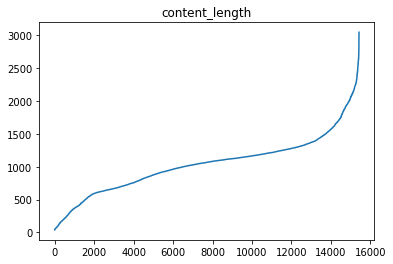

In [ ]:
plt.title('content_length') #content非常长，绝大部分都远大于512
plt.plot(sorted(train_df.content_len))
plt.show()

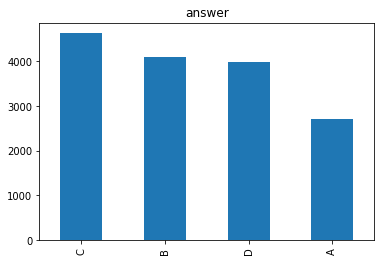

In [ ]:
plt.title('answer') #答案个数，C最多
train_df.Answer.value_counts().plot.bar()
plt.show()

In [ ]:
train_df['num_choices'] = train_df.Choices.apply(lambda x:len(x)) #绝大多数是四个选项
train_df['num_choices'].value_counts()

4    15329
3       71
2       25
Name: num_choices, dtype: int64

# 代码部分

In [ ]:
import json 
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import random
import os
import time
from sklearn.model_selection import *
!pip install transformers
from transformers import *

     |████████████████████████████████| 1.9MB 12.3MB/s 
     |████████████████████████████████| 890kB 66.8MB/s 
     |████████████████████████████████| 3.2MB 58.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=251b2fd8648bf3dd85401930cfbf683e84c35cfd32c1901a55203579ff138683
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
CFG = { #训练的参数配置
    'fold_num': 3, #五折交叉验证
    'seed': 42,
    'model': 'hfl/chinese-bert-wwm-ext', #预训练模型
    'max_len': 512, #文本截断的最大长度
    'epochs': 8,
    'train_bs': 4, #batch_size，可根据自己的显存调整
    'valid_bs': 4,
    'lr': 2e-5, #学习率
    'num_workers': 16,
    'accum_iter': 4, #梯度累积，相当于将batch_size*2
    'weight_decay': 1e-4, #权重衰减，防止过拟合
    'device': 0,
}

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['seed']) #固定随机种子

torch.cuda.set_device(CFG['device'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_df =  pd.read_csv('/content/drive/MyDrive/data/haihua/tmp/train.csv')
test_df =  pd.read_csv('/content/drive/MyDrive/data/haihua/tmp/test.csv')

In [ ]:
train_df['label'] = train_df['Answer'].apply(lambda x:['A','B','C','D'].index(x)) #将标签从ABCD转成0123
test_df['label'] = 0

In [ ]:
tokenizer = BertTokenizer.from_pretrained(CFG['model']) #加载bert的分词器

In [ ]:
class MyDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx): #将一条数据从(文章,问题,4个选项)转成(文章,问题,选项1)、(文章,问题,选项2)...
        label = self.df.label.values[idx]
        question = self.df.Question.values[idx]
        content = self.df.Content.values[idx]
        choice = self.df.Choices.values[idx][2:-2].split('\', \'')
        if len(choice) < 4: #如果选项不满四个，就补“不知道”
            for i in range(4-len(choice)):
                choice.append('D．不知道')
        
        content = [content for i in range(len(choice))]
        pair = [question + ' ' + i[2:] for i in choice]
        
        return content, pair, label

In [ ]:
def collate_fn(data): #将文章问题选项拼在一起后，得到分词后的数字id，输出的size是(batch, n_choices, max_len)
    input_ids, attention_mask, token_type_ids = [], [], []
    for x in data:
        text = tokenizer(x[1], text_pair=x[0], padding='max_length', truncation=True, max_length=CFG['max_len'], return_tensors='pt')
        input_ids.append(text['input_ids'].tolist())
        attention_mask.append(text['attention_mask'].tolist())
        token_type_ids.append(text['token_type_ids'].tolist())
    input_ids = torch.tensor(input_ids)
    attention_mask = torch.tensor(attention_mask)
    token_type_ids = torch.tensor(token_type_ids)
    label = torch.tensor([x[-1] for x in data])
    return input_ids, attention_mask, token_type_ids, label

In [ ]:
class AverageMeter: #为了tqdm实时显示loss和acc
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
        
def train_model(model, train_loader): #训练一个epoch
    model.train() 
    
    losses = AverageMeter()
    accs = AverageMeter()
    
    optimizer.zero_grad()
    
    tk = tqdm(train_loader, total=len(train_loader), position=0, leave=True)
    
    for step, (input_ids, attention_mask, token_type_ids, y) in enumerate(tk):
        input_ids, attention_mask, token_type_ids, y = input_ids.to(device), attention_mask.to(device), token_type_ids.to(device), y.to(device).long()

        with autocast(): #使用半精度训练
            output = model(input_ids, attention_mask, token_type_ids).logits

            loss = criterion(output, y) / CFG['accum_iter']
            scaler.scale(loss).backward()
            
            if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)): #梯度累加
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad() 
                scheduler.step()
        
        acc = (output.argmax(1)==y).sum().item()/y.size(0)
        
        losses.update(loss.item()*CFG['accum_iter'], y.size(0))
        accs.update(acc, y.size(0))
        
        tk.set_postfix(loss=losses.avg, acc=accs.avg)
        
    return losses.avg, accs.avg


def test_model(model, val_loader): #验证
    model.eval()
    
    losses = AverageMeter()
    accs = AverageMeter()

    y_truth, y_pred = [], []
    
    with torch.no_grad():
        tk = tqdm(val_loader, total=len(val_loader), position=0, leave=True)
        for idx, (input_ids, attention_mask, token_type_ids, y) in enumerate(tk):
            input_ids, attention_mask, token_type_ids, y = input_ids.to(device), attention_mask.to(device), token_type_ids.to(device), y.to(device).long()

            output = model(input_ids, attention_mask, token_type_ids).logits
            
            y_truth.extend(y.cpu().numpy())
            y_pred.extend(output.argmax(1).cpu().numpy())
            
            loss = criterion(output, y) 

            acc = (output.argmax(1)==y).sum().item()/y.size(0)
            
            losses.update(loss.item(), y.size(0))
            accs.update(acc, y.size(0))
  
            tk.set_postfix(loss=losses.avg, acc=accs.avg)
            
       
    return losses.avg, accs.avg

In [ ]:
seed_everything(CFG['seed'])

folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed'])\
                    .split(np.arange(train_df.shape[0]), train_df.label.values) #五折交叉验证

cv = [] #保存每折的最佳准确率

for fold, (trn_idx, val_idx) in enumerate(folds):

    train = train_df.loc[trn_idx]
    val = train_df.loc[val_idx]
    
    train_set = MyDataset(train)
    val_set = MyDataset(val)
    
    train_loader = DataLoader(train_set, batch_size=CFG['train_bs'], collate_fn=collate_fn, shuffle=True, num_workers=CFG['num_workers'])
    val_loader = DataLoader(val_set, batch_size=CFG['valid_bs'], collate_fn=collate_fn, shuffle=False, num_workers=CFG['num_workers'])
    
    best_acc = 0
    
    model =  BertForMultipleChoice.from_pretrained(CFG['model']).to(device) #模型

    scaler = GradScaler()
    optimizer = AdamW(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay']) #AdamW优化器
    criterion = nn.CrossEntropyLoss()
    scheduler = get_cosine_schedule_with_warmup(optimizer, len(train_loader)//CFG['accum_iter'], CFG['epochs']*len(train_loader)//CFG['accum_iter'])
#get_cosine_schedule_with_warmup策略，学习率先warmup一个epoch，然后cos式下降

    for epoch in range(CFG['epochs']):

        print('epoch:',epoch)
        time.sleep(0.2)

        train_loss, train_acc = train_model(model, train_loader)
        val_loss, val_acc = test_model(model, val_loader)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), '{}_fold_{}.pt'.format(CFG['model'].split('/')[-1], fold))
            
    cv.append(best_acc) 

Some weights of the model checkpoint at hfl/chinese-bert-wwm-ext were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at hfl/chinese-bert-wwm-ext

epoch: 0


  0%|          | 3/2571 [00:02<58:26,  1.37s/it, acc=0.333, loss=1.36]  /usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 1286/1286 [03:32<00:00,  6.04it/s, acc=0.279, loss=1.38]


epoch: 1


100%|██████████| 1286/1286 [03:32<00:00,  6.05it/s, acc=0.349, loss=1.33]


epoch: 2


100%|██████████| 1286/1286 [03:32<00:00,  6.05it/s, acc=0.412, loss=1.29]


epoch: 3


100%|██████████| 1286/1286 [03:32<00:00,  6.05it/s, acc=0.418, loss=1.39]


epoch: 4


100%|██████████| 1286/1286 [03:32<00:00,  6.05it/s, acc=0.432, loss=1.75]


epoch: 5


100%|██████████| 1286/1286 [03:32<00:00,  6.05it/s, acc=0.439, loss=2.15]


epoch: 6


100%|██████████| 1286/1286 [03:32<00:00,  6.05it/s, acc=0.44, loss=2.48]


epoch: 7


100%|██████████| 1286/1286 [03:32<00:00,  6.05it/s, acc=0.439, loss=2.59]
Some weights of the model checkpoint at hfl/chinese-bert-wwm-ext were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice 

epoch: 0


100%|██████████| 1286/1286 [03:30<00:00,  6.10it/s, acc=0.263, loss=1.39]


epoch: 1


100%|██████████| 1286/1286 [03:32<00:00,  6.05it/s, acc=0.295, loss=1.38]


epoch: 2


100%|██████████| 1286/1286 [03:29<00:00,  6.13it/s, acc=0.245, loss=1.39]


epoch: 3


100%|██████████| 1286/1286 [03:29<00:00,  6.13it/s, acc=0.241, loss=1.39]


epoch: 4


100%|██████████| 1286/1286 [03:30<00:00,  6.10it/s, acc=0.254, loss=1.39]


epoch: 5


100%|██████████| 1286/1286 [03:29<00:00,  6.13it/s, acc=0.253, loss=1.39]


epoch: 6


100%|██████████| 1286/1286 [03:29<00:00,  6.13it/s, acc=0.257, loss=1.39]


epoch: 7


100%|██████████| 1286/1286 [03:29<00:00,  6.13it/s, acc=0.251, loss=1.39]
Some weights of the model checkpoint at hfl/chinese-bert-wwm-ext were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice 

epoch: 0


100%|██████████| 1286/1286 [03:31<00:00,  6.09it/s, acc=0.305, loss=1.38]


epoch: 1


100%|██████████| 1286/1286 [03:31<00:00,  6.08it/s, acc=0.336, loss=1.35]


epoch: 2


100%|██████████| 1286/1286 [03:31<00:00,  6.08it/s, acc=0.407, loss=1.28]


epoch: 3


100%|██████████| 1286/1286 [03:31<00:00,  6.08it/s, acc=0.429, loss=1.39]


epoch: 4


100%|██████████| 1286/1286 [03:31<00:00,  6.08it/s, acc=0.433, loss=1.68]


epoch: 5


100%|██████████| 1286/1286 [03:31<00:00,  6.08it/s, acc=0.43, loss=2.24]


epoch: 6


100%|██████████| 1286/1286 [03:31<00:00,  6.07it/s, acc=0.429, loss=2.46]


epoch: 7


100%|██████████| 1286/1286 [03:31<00:00,  6.08it/s, acc=0.428, loss=2.55]


In [ ]:
test_set = MyDataset(test_df)
test_loader = DataLoader(test_set, batch_size=CFG['valid_bs'], collate_fn=collate_fn, shuffle=False, num_workers=CFG['num_workers'])

In [ ]:
model =  BertForMultipleChoice.from_pretrained(CFG['model']).to(device)

predictions = []

for fold in range(CFG['fold_num']): #把训练后的五个模型挨个进行预测
    y_pred = []
    model.load_state_dict(torch.load('{}_fold_{}.pt'.format(CFG['model'].split('/')[-1], fold)))
    
    with torch.no_grad():
        tk = tqdm(test_loader, total=len(test_loader), position=0, leave=True)
        for idx, (input_ids, attention_mask, token_type_ids, y) in enumerate(tk):
            input_ids, attention_mask, token_type_ids, y = input_ids.to(device), attention_mask.to(device), token_type_ids.to(device), y.to(device).long()

            output = model(input_ids, attention_mask, token_type_ids).logits.cpu().numpy()

            y_pred.extend(output)
            
    predictions += [y_pred]

Some weights of the model checkpoint at hfl/chinese-bert-wwm-ext were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at hfl/chinese-bert-wwm-ext

In [ ]:
predictions = np.mean(predictions,0).argmax(1) #将结果按五折进行平均，然后argmax得到label

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/data/haihua/sample.csv',dtype=object) #提交
sub['label'] = predictions
sub['label'] = sub['label'].apply(lambda x:['A','B','C','D'][x])

sub.to_csv('/content/drive/MyDrive/data/haihua/tmp/sub01.csv',index=False)

In [ ]:
np.mean(cv)

0.3893707622663097